In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('online_shoppers_intention.csv')
df.drop_duplicates(inplace=True, keep = 'first')

### Turn string type to int/float


In [3]:
month_mapping = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4,
    'May': 5, 'June': 6, 'Jul': 7, 'Aug': 8,
    'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}

df['Month'] = df['Month'].map(month_mapping)

### Encoding the visitor_type

In [4]:
df_encoded = pd.get_dummies(df, columns=['VisitorType', 'Browser', 'Region', 'OperatingSystems','TrafficType'])
df_encoded

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,TrafficType_11,TrafficType_12,TrafficType_13,TrafficType_14,TrafficType_15,TrafficType_16,TrafficType_17,TrafficType_18,TrafficType_19,TrafficType_20
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,...,False,False,False,False,False,False,False,False,False,False
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.000000,0.0,...,False,False,False,False,False,False,False,False,False,False
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,...,False,False,False,False,False,False,False,False,False,False
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.000000,0.0,...,False,False,False,False,False,False,False,False,False,False
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.000000,0.0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,3,145.0,0,0.0,53,1783.791667,0.007143,0.029031,12.241717,0.0,...,False,False,False,False,False,False,False,False,False,False
12326,0,0.0,0,0.0,5,465.750000,0.000000,0.021333,0.000000,0.0,...,False,False,False,False,False,False,False,False,False,False
12327,0,0.0,0,0.0,6,184.250000,0.083333,0.086667,0.000000,0.0,...,False,False,True,False,False,False,False,False,False,False
12328,4,75.0,0,0.0,15,346.000000,0.000000,0.021053,0.000000,0.0,...,True,False,False,False,False,False,False,False,False,False


# Modeling

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

df_train, df_test = train_test_split(df_encoded, test_size = 0.1, random_state=42)
X_test = df_test.drop('Revenue', axis = 1)
y_test = df_test['Revenue'].copy()
df_train, df_val = train_test_split(df_train, test_size = 0.1, random_state=42)
X_train = df_train.drop('Revenue', axis = 1)
y_train = df_train['Revenue'].copy()
X_val = df_test.drop('Revenue', axis = 1)
y_val = df_test['Revenue'].copy()

In [8]:
def evaluate(y_val, y_pred, y_probs):
    # Evaluation
    conf_matrix = confusion_matrix(y_val, y_pred)
    print(classification_report(y_val, y_pred, digits=3))

    # confusion matrix
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # ROC Curve and AUC
    fpr, tpr, thresholds = roc_curve(y_val, y_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

def grid_search(param_grid, pipe, X_train, y_train):
    grid_search = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5, scoring='roc_auc', verbose=0)

    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    print("Best parameters:", best_params)

    best_score = grid_search.best_score_
    print("Best score:", best_score)

    return grid_search.best_estimator_

### SVM

Best parameters: {'classifier__C': 10, 'classifier__kernel': 'linear'}
Best score: 0.9003982429320588
              precision    recall  f1-score   support

       False      0.952     0.904     0.927      1042
        True      0.567     0.732     0.639       179

    accuracy                          0.879      1221
   macro avg      0.759     0.818     0.783      1221
weighted avg      0.895     0.879     0.885      1221



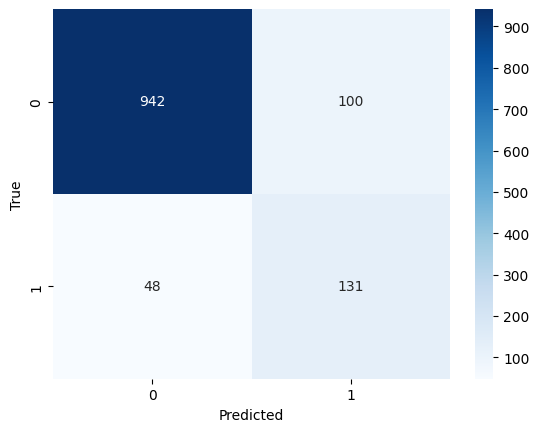

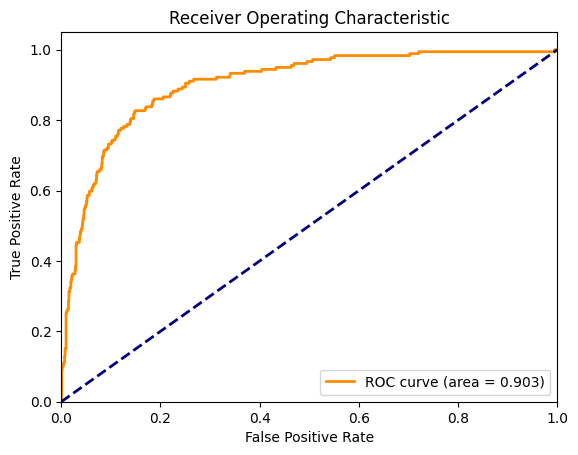

In [9]:
from sklearn.svm import SVC

pipe = ImbPipeline([('scaler', StandardScaler()), 
                 ('smote', SMOTE(random_state=42)),
                 ('classifier', SVC(probability=True))])

# Define the parameter grid
param_grid = {
    'classifier__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'classifier__C': [0.1, 1, 10]
}

best_estimator_svm = grid_search(param_grid, pipe, X_train, y_train)

y_pred = best_estimator_svm.predict(X_val)
y_probs = best_estimator_svm.predict_proba(X_val)[:, 1]  # the probability of the positive class

evaluate(y_val, y_pred, y_probs)

## Logistic Regression

Best parameters: {'classifier__C': 0.1}
Best score: 0.8888716450258336
              precision    recall  f1-score   support

       False      0.953     0.886     0.918      1042
        True      0.528     0.743     0.617       179

    accuracy                          0.865      1221
   macro avg      0.740     0.814     0.768      1221
weighted avg      0.890     0.865     0.874      1221



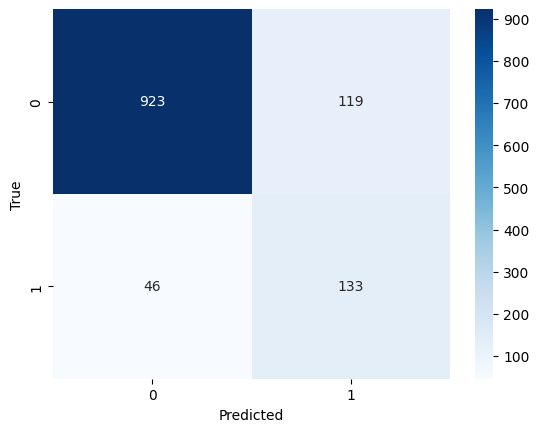

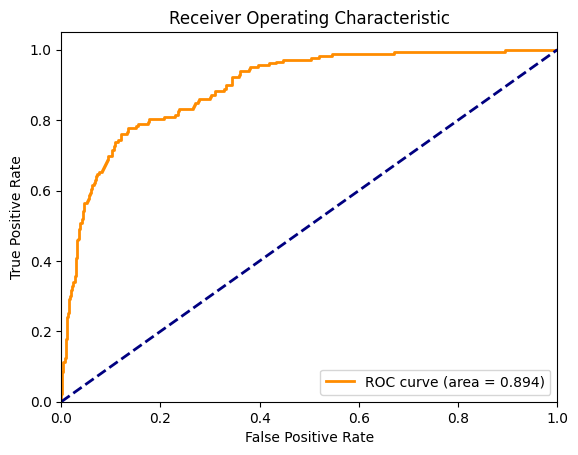

In [10]:
from sklearn.linear_model import LogisticRegression

pipe = ImbPipeline([('scaler', StandardScaler()), 
                 ('smote', SMOTE(random_state=42)),
                 ('classifier', LogisticRegression())])
param_grid = {
    'classifier__C': [ 0.01, 0.1, 1, 10]
}

best_estimator_lr = grid_search(param_grid, pipe, X_train, y_train)

y_pred = best_estimator_lr.predict(X_val)
y_probs = best_estimator_lr.predict_proba(X_val)[:, 1]  # the probability of the positive class

evaluate(y_val, y_pred, y_probs)

## Decision Tree

Best parameters: {'classifier__max_depth': 5, 'classifier__min_samples_leaf': 50}
Best score: 0.9140011997600478
              precision    recall  f1-score   support

       False      0.956     0.905     0.930      1042
        True      0.579     0.760     0.657       179

    accuracy                          0.884      1221
   macro avg      0.768     0.832     0.793      1221
weighted avg      0.901     0.884     0.890      1221



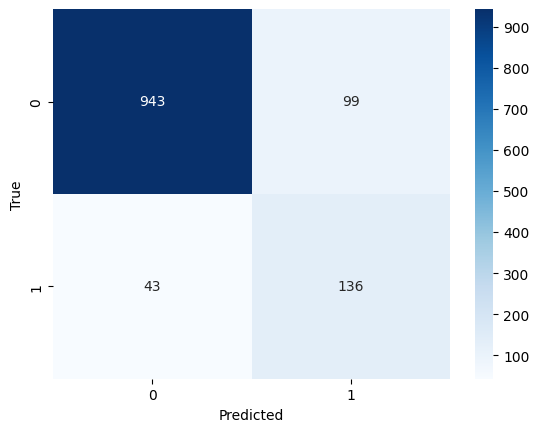

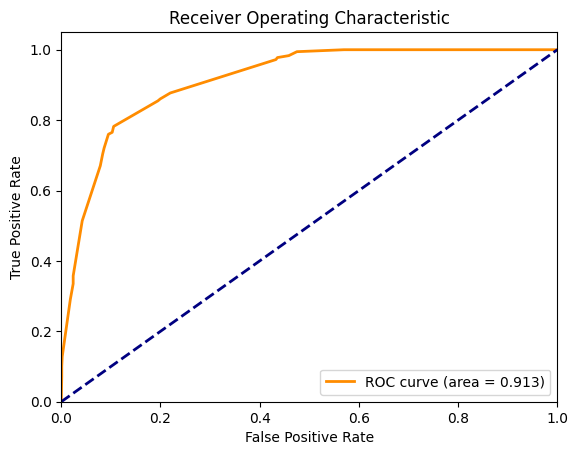

In [11]:
from sklearn.tree import DecisionTreeClassifier

pipe = ImbPipeline([('scaler', StandardScaler()), 
                 ('smote', SMOTE(random_state=42)),
                 ('classifier', DecisionTreeClassifier(criterion='entropy', random_state=42))])
param_grid = {
    'classifier__max_depth': [5, 10, None],
    'classifier__min_samples_leaf': [1, 5, 50]
}

best_estimator_dt = grid_search(param_grid, pipe, X_train, y_train)

y_pred = best_estimator_dt.predict(X_val)
y_probs = best_estimator_dt.predict_proba(X_val)[:, 1]  # the probability of the positive class

evaluate(y_val, y_pred, y_probs)

## Random Forest

Best parameters: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 5, 'classifier__n_estimators': 200}
Best score: 0.9213928827137797
              precision    recall  f1-score   support

       False      0.958     0.902     0.929      1042
        True      0.575     0.771     0.659       179

    accuracy                          0.883      1221
   macro avg      0.767     0.837     0.794      1221
weighted avg      0.902     0.883     0.890      1221



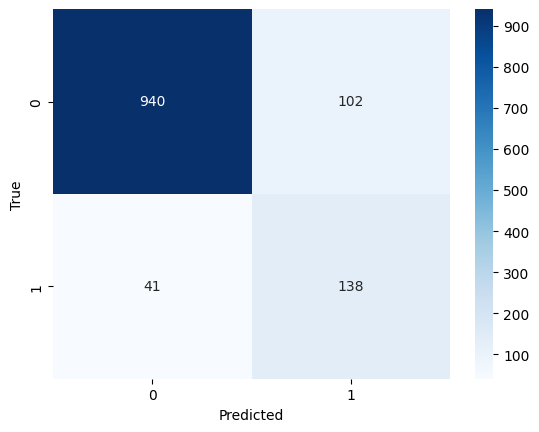

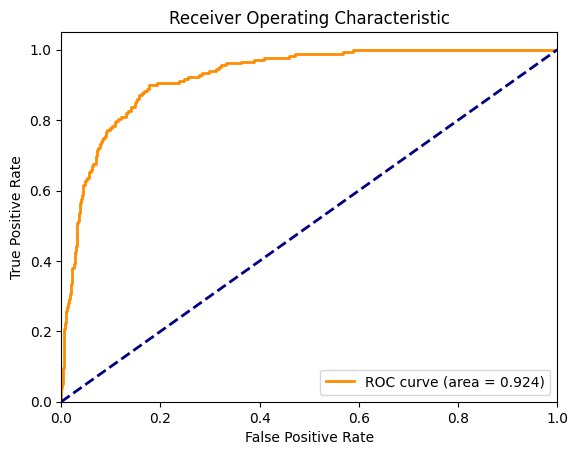

In [12]:
from sklearn.ensemble import RandomForestClassifier

pipe = ImbPipeline([('scaler', StandardScaler()), 
                 ('smote', SMOTE(random_state=42)),
                 ('classifier', RandomForestClassifier(criterion='entropy', random_state=42))])
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [5, 10, None],
    'classifier__min_samples_leaf': [1, 5, 50]
}

best_estimator_rf = grid_search(param_grid, pipe, X_train, y_train)

y_pred = best_estimator_rf.predict(X_val)
y_probs = best_estimator_rf.predict_proba(X_val)[:, 1]  # the probability of the positive class

evaluate(y_val, y_pred, y_probs)

## Gradient Boost Decision Tree

Best parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 100}
Best score: 0.9269777657371752
              precision    recall  f1-score   support

       False      0.951     0.932     0.941      1042
        True      0.645     0.721     0.681       179

    accuracy                          0.901      1221
   macro avg      0.798     0.826     0.811      1221
weighted avg      0.906     0.901     0.903      1221



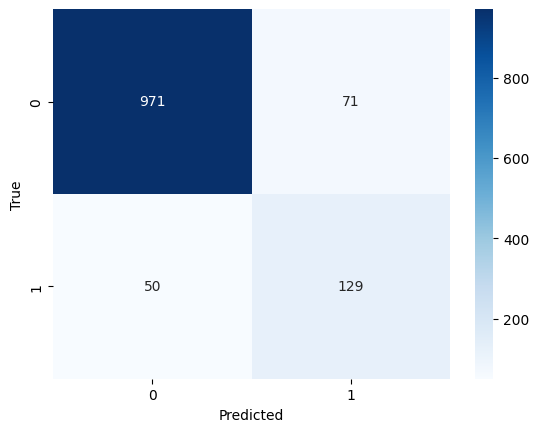

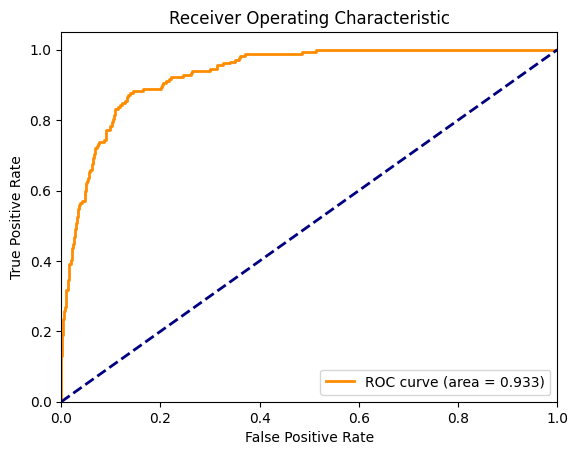

In [13]:
from xgboost import XGBClassifier

pipe = ImbPipeline([('scaler', StandardScaler()), 
                 ('smote', SMOTE(random_state=42)),
                 ('classifier', XGBClassifier(random_state=42))])
param_grid = {
    'classifier__learning_rate': [0.01, 0.1, 0.5],
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [5, 10, None],
}

best_estimator_gbdt = grid_search(param_grid, pipe, X_train, y_train)

y_pred = best_estimator_gbdt.predict(X_val)
y_probs = best_estimator_gbdt.predict_proba(X_val)[:, 1]  # the probability of the positive class

evaluate(y_val, y_pred, y_probs)